In [3]:
!python --version

Python 3.6.6


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Désactive le GPU et utilise le CPU uniquement car pas de GPU


In [5]:
import tensorflow as tf
import skimage
import keras

print("TensorFlow version:", tf.__version__)
print("scikit-image version:", skimage.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 1.15.0
scikit-image version: 0.17.2
Keras version: 2.1.6


In [6]:

# List available GPUs
gpus = tf.GPUOptions()

# Check for available devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU') if hasattr(tf, 'config') else tf.test.gpu_device_name()

# Print the number of available GPUs
if gpu_devices:
    print("Num GPUs Available: ", len(gpu_devices))
else:
    print("No GPUs available")


No GPUs available


In [7]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [8]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [9]:
from mrcnn.config import Config

class DroneConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Pas de GPU
    IMAGES_PER_GPU = 1  # Une image à la fois sur le CPU
    NUM_CLASSES = 1 + 1  # Background + classes "drone"
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ["bg", "drone"]
    IMAGE_MAX_DIM = 512

config = DroneConfig()

In [10]:
import os
import json
import numpy as np
from skimage.io import imread
from mrcnn.utils import Dataset
from sklearn.model_selection import train_test_split
from skimage.draw import polygon as draw_polygon  # Correctly import the draw_polygon function

class DroneDataset(Dataset):
    def load_drone(self, dataset_dir, subset):
        """
        Load a subset of the drone dataset where each image has its own annotation JSON file.
        Args:
            dataset_dir: Root directory of the dataset.
            subset: Subset to load (train/val/test).
        """
        # Add a single class for "drone"
        self.add_class("drone", 1, "drone")
        
        # Define the directory for this subset (train/val/test)
        subset_dir = os.path.join(dataset_dir, subset)
        
        # Define and check image and annotation directories
        image_dir = os.path.join(subset_dir, "images")
        annotation_dir = os.path.join(subset_dir, "annotations")
        
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.exists(annotation_dir):
            raise FileNotFoundError(f"Annotation directory not found: {annotation_dir}")
        
        # List all image files in the subset directory
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))]
        
        # Initialize an empty list to hold all annotations
        annotations = []

        # Iterate through image files and corresponding annotations
        for image_file in image_files:
            # Full path to image
            image_path = os.path.join(image_dir, image_file)

            # Extract the image ID (without file extension)
            image_id = os.path.splitext(image_file)[0]

            # Load the corresponding annotation JSON file
            annotation_path = os.path.join(annotation_dir, f"{image_id}.json")
            
            if not os.path.exists(annotation_path):
                print(f"Warning: Annotation file not found for {image_file}")
                continue
            
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)

            # Append the annotation to the annotations list
            annotations.append(annotation)

            # Extract image dimensions and annotations
            width = annotation['imageWidth']
            height = annotation['imageHeight']
            polygons = annotation['shapes']  # Modify based on actual format in your annotation file

            # Add the image and its annotations to the dataset
            self.add_image(
                "drone",
                image_id=image_id,  # Use image file name (without extension) as the image_id
                path=image_path,
                width=width,
                height=height,
                annotations=polygons  # Pass the loaded annotations
            )

        # Split dataset if it's for training
        if subset == "train":
            train_anns, val_anns = train_test_split(annotations, test_size=0.2, random_state=42)
            annotations = train_anns
        elif subset == "val":
            _, annotations = train_test_split(annotations, test_size=0.2, random_state=42)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Args:
            image_id: ID of the image to load.
        Returns:
            masks: A 3D array [height, width, instance count] with a binary mask per instance.
            class_ids: A 1D array of class IDs corresponding to the instances.
            bboxes: A list of bounding boxes for each mask.
        """
        # Get image info
        info = self.image_info[image_id]
        annotations = info['annotations']

        # Height and width of the image
        height = info['height']
        width = info['width']

        # Initialize mask array: one binary mask per instance
        masks = np.zeros([height, width, len(annotations)], dtype=np.uint8)

        # Class IDs array (we only have one class, "drone")
        class_ids = np.ones([len(annotations)], dtype=np.int32)

        # List to hold bounding boxes
        bboxes = []

        # Loop over each annotation (polygon or mask)
        for i, annotation in enumerate(annotations):
            # Get the polygon points for the object
            polygon = annotation['points']  # Modify based on your annotation file structure

            # Convert polygon to a binary mask using the class method
            mask = self.polygon_to_mask(polygon, height, width)
            masks[:, :, i] = mask  # Assign the binary mask for the object

            # Get bounding box
            x_min = min(p[0] for p in polygon)
            y_min = min(p[1] for p in polygon)
            x_max = max(p[0] for p in polygon)
            y_max = max(p[1] for p in polygon)
            bboxes.append([y_min, x_min, y_max, x_max])

        return masks, class_ids

    def polygon_to_mask(self, polygon, height, width):
        """Helper function to convert a polygon into a binary mask.
        Args:
            polygon: List of polygon points in [(x1, y1), (x2, y2), ...] format.
            height, width: Dimensions of the mask.
        Returns:
            mask: A binary mask with the polygon area set to 1.
        """
        # Create an empty mask
        mask = np.zeros((height, width), dtype=np.uint8)

        # Separate x and y coordinates from the polygon points
        poly_x = [p[0] for p in polygon]
        poly_y = [p[1] for p in polygon]

        # Draw the polygon on the mask
        rr, cc = draw_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1

        return mask


In [11]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\GHO\Mask_RCNN


In [12]:


dataset = DroneDataset()
dataset_dir = os.path.join(os.getcwd(), "Mask_RCNN")

dataset.load_drone(dataset_dir="dataset", subset="train")

image_id = 7  # Test with the first image
image = dataset.load_image(image_id)

# Correctly unpack the three values returned by load_mask
mask, class_ids = dataset.load_mask(image_id)

# Print the results to check correctness
print("Mask shape:", mask.shape)
print("Class IDs:", class_ids)


Mask shape: (683, 1024, 1)
Class IDs: [1]


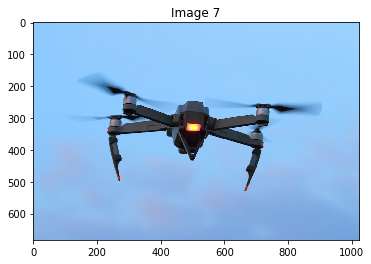

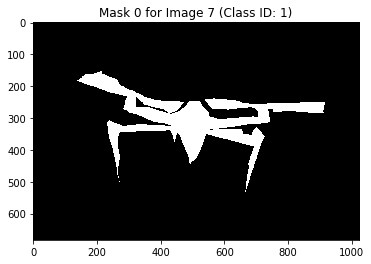

In [11]:
import matplotlib.pyplot as plt

# Visualize an image and its mask
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Show the image
plt.imshow(image)
plt.title(f"Image {image_id}")
plt.show()

# Show the masks
for i in range(mask.shape[-1]):
    plt.imshow(mask[:, :, i], cmap='gray')
    plt.title(f"Mask {i} for Image {image_id} (Class ID: {class_ids[i]})")
    plt.show()


In [12]:
# Import the model
from mrcnn.model import MaskRCNN

# Create a new Mask R-CNN model in training mode
model = MaskRCNN(mode="training", config=config, model_dir="./logs")

# Load pre-trained weights (exclude layers that don't match our classes)
model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [16]:
import os
# Prepare the training dataset (80% of the data)
train_dataset = DroneDataset()
train_dataset.load_drone(dataset_dir="dataset", subset="train")
train_dataset.prepare()

# Prepare the validation dataset (20% of the data)
val_dataset = DroneDataset()
val_dataset.load_drone(dataset_dir="dataset", subset="val")
val_dataset.prepare()


In [14]:
model.train(train_dataset, val_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')
model.keras_model.save_weights("model.h5")


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs\drone_detection20241123T1349\mask_rcnn_drone_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Print available devices
print(device_lib.list_local_devices())


In [14]:
print("Model Configuration:")
config.display()


Model Configuration:

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

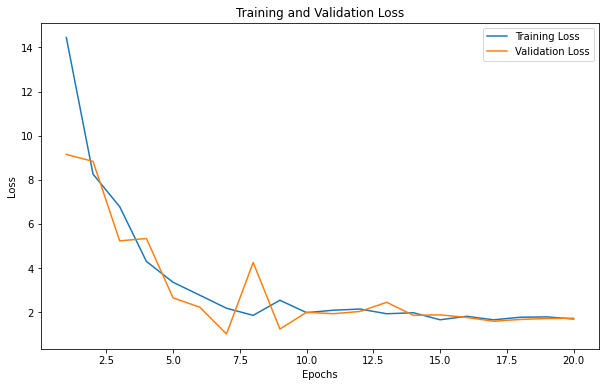

In [2]:
import matplotlib.pyplot as plt

# Données des époques
epochs = range(1, 21)

# Pertes d'entraînement et de validation
loss = [14.4516, 8.2569, 6.7783, 4.2977, 3.3512, 2.7660, 2.1746, 1.8516, 2.5367, 1.9750, 2.0846, 2.1384, 1.9251, 1.9702, 1.6521, 1.8095, 1.6503, 1.7661, 1.7817, 1.6875]
val_loss = [9.1481, 8.8341, 5.2290, 5.3369, 2.6433, 2.2224, 1.0080, 4.2507, 1.2310, 1.9927, 1.9265, 2.0286, 2.4443, 1.8525, 1.8747, 1.7577, 1.5852, 1.6656, 1.7090, 1.7234]

# Tracer les courbes de pertes
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [13]:
import tensorflow as tf
from mrcnn.model import MaskRCNN

# Initialiser une liste pour stocker les modèles
models = []

# Définir la structure de ton modèle
def get_model():
    model = MaskRCNN(mode="training", config=config, model_dir="logs")
    return model

# Charger les poids pour chaque époque
for epoch in range(1, 21):
    model_path = f'logs/drone_detection20241123T1349/mask_rcnn_drone_detection_{epoch:04d}.h5'
    model = get_model()
    model.load_weights(model_path, by_name=True)  
    models.append(model)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Re-starting from epoch 1
Re-starting from epoch 2
Re-starting from epoch 3
Re-starting from epoch 4
Re-starting from epoch 5
Re-starting from epoch 6
Re-starting from epoch 7
Re-starting from epoch 8
Re-starting from epoch 9
Re-starting from epoch 10
Re-starting from epoch 11
Re-starting from epoch 12
Re-starting from epoch 13
Re-starting from epoch 14
Re-starting from epoch 15
Re-starting from epoch 16
Re-starting from epoch 17
Re-starting from epoch 18
Re-starting from epoch 19
Re-starting from epoch 20


In [14]:
import numpy as np
from tqdm import tqdm

def evaluer_drone_model(model, dataset, config):
    """
    Évalue le modèle Mask R-CNN sur le DroneDataset
    """
    print("Début de l'évaluation...")
    print(f"Nombre d'images dans le dataset: {len(dataset.image_ids)}")
    
    # Initialiser la matrice de confusion
    num_classes = len(config.CLASS_NAMES)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    # Pour chaque image dans le dataset
    for image_id in tqdm(dataset.image_ids):
        # Charger l'image
        image = dataset.load_image(image_id)
        if image is None:
            print(f"Erreur: Impossible de charger l'image {image_id}")
            continue
            
        # Charger les masques et classes de vérité terrain
        gt_masks, gt_class_ids = dataset.load_mask(image_id)
        if gt_masks is None or len(gt_class_ids) == 0:
            print(f"Attention: Pas de masques trouvés pour l'image {image_id}")
            continue
            
        print(f"\nImage {image_id}:")
        print(f"Classes vérité terrain: {gt_class_ids}")
        
        # Faire les prédictions
        # Assurez-vous que la taille du batch est 1 pour chaque image dans l'évaluation
        config.BATCH_SIZE = 1
        results = model.detect([image], verbose=0)[0]
        pred_class_ids = results['class_ids']
        pred_masks = results['masks']
        scores = results['scores']
        
        print(f"Classes prédites: {pred_class_ids}")
        print(f"Scores: {scores}")
        
        # Pour chaque prédiction, trouver la meilleure correspondance
        for i, pred_class in enumerate(pred_class_ids):
            best_iou = 0
            best_gt_idx = -1
            
            # Comparer avec chaque masque de vérité terrain
            for j, gt_class in enumerate(gt_class_ids):
                pred_mask = pred_masks[:, :, i]
                gt_mask = gt_masks[:, :, j]
                
                # Calculer IoU
                iou = calculate_iou(pred_mask, gt_mask)
                if iou > best_iou and iou >= 0.5:  # Seuil IoU de 0.5
                    best_iou = iou
                    best_gt_idx = j
            
            if best_gt_idx >= 0:
                # Ajouter à la matrice de confusion
                gt_class = gt_class_ids[best_gt_idx] - 1  # -1 car les classes commencent à 1
                pred_class = pred_class - 1
                confusion_matrix[gt_class, pred_class] += 1
                print(f"Match trouvé: Classe GT {gt_class+1} -> Pred {pred_class+1} (IoU: {best_iou:.3f})")
    
    return confusion_matrix

def calculate_iou(mask1, mask2):
    """
    Calcule l'Intersection over Union entre deux masques
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

def afficher_metriques(confusion_matrix, class_names):
    """
    Affiche les métriques pour chaque classe
    """
    print("\nMétriques par classe:")
    print("-" * 50)
    
    for i, class_name in enumerate(class_names):
        if confusion_matrix[i].sum() + confusion_matrix[:, i].sum() == 0:
            continue
            
        # Calculer précision et rappel
        true_positives = confusion_matrix[i, i]
        false_positives = confusion_matrix[:, i].sum() - true_positives
        false_negatives = confusion_matrix[i, :].sum() - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClasse {class_name}:")
        print(f"Précision: {precision:.3f}")
        print(f"Rappel: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")


Re-starting from epoch 20
Évaluation du modèle sur le dataset de validation...
Début de l'évaluation...
Nombre d'images dans le dataset: 47


  0%|                                                                                           | 0/47 [00:00<?, ?it/s]


Image 0:
Classes vérité terrain: [1]








  2%|█▋                                                                               | 1/47 [01:39<1:16:11, 99.37s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 1:
Classes vérité terrain: [1]


  4%|███▌                                                                               | 2/47 [01:45<33:30, 44.68s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1.]

Image 2:
Classes vérité terrain: [1]


  6%|█████▎                                                                             | 3/47 [01:51<19:49, 27.04s/it]

Classes prédites: [1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1.]

Image 3:
Classes vérité terrain: [1]


  9%|███████                                                                            | 4/47 [01:57<13:23, 18.69s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1.         1.         0.9999999  0.99999976 0.99999976 0.99999976
 0.99999964 0.99999964 0.99999964 0.99999964 0.99999964 0.99999964
 0.99999964 0.99999964]

Image 4:
Classes vérité terrain: [1]


 11%|████████▊                                                                          | 5/47 [02:03<09:56, 14.21s/it]

Classes prédites: [1 1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994
 0.9999994]

Image 5:
Classes vérité terrain: [1]


 13%|██████████▌                                                                        | 6/47 [02:10<07:52, 11.52s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]

Image 6:
Classes vérité terrain: [1]


 15%|████████████▎                                                                      | 7/47 [02:16<06:33,  9.84s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994
 0.9999994 0.9999994]

Image 7:
Classes vérité terrain: [1 1 1]
Classes prédites: [1 1 1 1 1 1 1 1]
Scores: [0.99999964 0.99999964 0.99999964 0.99999964 0.99999964 0.99999964
 0.99999964 0.99999964]


 17%|██████████████▏                                                                    | 8/47 [02:23<05:41,  8.75s/it]


Image 8:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1.         1.         1.         1.         1.         1.
 1.         1.         0.9999999  0.9999999  0.9999999  0.99999976
 0.99999976 0.9999995  0.9999995  0.9999995  0.9999995  0.9999995
 0.9999995  0.9999995  0.9999995 ]


 19%|███████████████▉                                                                   | 9/47 [02:29<05:08,  8.13s/it]


Image 9:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994]


 21%|█████████████████▍                                                                | 10/47 [02:37<04:58,  8.08s/it]


Image 10:
Classes vérité terrain: [1]


 23%|███████████████████▏                                                              | 11/47 [02:44<04:37,  7.71s/it]

Classes prédites: [1 1 1 1 1 1 1 1]
Scores: [0.99999917 0.99999917 0.99999917 0.99999917 0.99999917 0.99999917
 0.99999917 0.99999917]

Image 11:
Classes vérité terrain: [1]


 26%|████████████████████▉                                                             | 12/47 [02:50<04:12,  7.20s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [1.        1.        1.        0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999]

Image 12:
Classes vérité terrain: [1]


 36%|█████████████████████████████▋                                                    | 17/47 [02:56<01:14,  2.49s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [0.9999999  0.9999999  0.9999999  0.99999976 0.99999964 0.99999964
 0.99999964 0.9999995  0.9999995  0.9999995  0.9999995  0.9999995
 0.9999995  0.9999995 ]
Attention: Pas de masques trouvés pour l'image 13
Attention: Pas de masques trouvés pour l'image 14
Attention: Pas de masques trouvés pour l'image 15
Attention: Pas de masques trouvés pour l'image 16
Attention: Pas de masques trouvés pour l'image 17

Image 18:
Classes vérité terrain: [1]


 40%|█████████████████████████████████▏                                                | 19/47 [03:02<01:13,  2.62s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 19:
Classes vérité terrain: [1]


 43%|██████████████████████████████████▉                                               | 20/47 [03:08<01:26,  3.21s/it]

Classes prédites: [1 1 1 1]
Scores: [0.99999976 0.99999976 0.99999976 0.99999976]

Image 20:
Classes vérité terrain: [1]


 45%|████████████████████████████████████▋                                             | 21/47 [03:14<01:37,  3.74s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999987 0.9999987 0.9999987 0.9999987 0.9999987 0.9999987 0.9999987]

Image 21:
Classes vérité terrain: [1]


 47%|██████████████████████████████████████▍                                           | 22/47 [03:19<01:45,  4.22s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 22:
Classes vérité terrain: [1]


 49%|████████████████████████████████████████▏                                         | 23/47 [03:25<01:49,  4.56s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 23:
Classes vérité terrain: [1]


 51%|█████████████████████████████████████████▊                                        | 24/47 [03:31<01:52,  4.88s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1]
Scores: [1.        0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999]

Image 24:
Classes vérité terrain: [1]


 53%|███████████████████████████████████████████▌                                      | 25/47 [03:36<01:52,  5.09s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1.         0.9999999  0.9999999  0.9999999  0.9999999  0.99999964
 0.99999964 0.9999995  0.9999995  0.9999995  0.9999995  0.9999995
 0.9999995  0.9999995 ]

Image 25:
Classes vérité terrain: [1]


 55%|█████████████████████████████████████████████▎                                    | 26/47 [03:42<01:50,  5.25s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.99999964 0.99999964 0.99999964 0.99999964 0.99999964 0.99999964
 0.99999964]

Image 26:
Classes vérité terrain: [1]


 57%|███████████████████████████████████████████████                                   | 27/47 [03:48<01:47,  5.36s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999993 0.9999993 0.9999993 0.9999993 0.9999993 0.9999993 0.9999993]
Attention: Pas de masques trouvés pour l'image 27

Image 28:
Classes vérité terrain: [1]


 62%|██████████████████████████████████████████████████▌                               | 29/47 [03:53<01:16,  4.23s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [0.9999999  0.99999976 0.99999964 0.9999995  0.9999995  0.9999995
 0.9999995  0.9999995  0.9999995  0.9999995 ]

Image 29:
Classes vérité terrain: [1]


 64%|████████████████████████████████████████████████████▎                             | 30/47 [03:59<01:18,  4.65s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [0.9999999  0.9999999  0.9999999  0.99999976 0.99999964 0.99999964
 0.99999964 0.9999995  0.9999995  0.9999994  0.9999994  0.9999994
 0.9999994  0.9999994  0.9999994 ]

Image 30:
Classes vérité terrain: [1]


 66%|██████████████████████████████████████████████████████                            | 31/47 [04:05<01:19,  4.94s/it]

Classes prédites: [1 1 1 1 1 1]
Scores: [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]

Image 31:
Classes vérité terrain: [1]


 68%|███████████████████████████████████████████████████████▊                          | 32/47 [04:11<01:17,  5.18s/it]

Classes prédites: [1 1 1 1 1 1]
Scores: [0.99999964 0.99999964 0.99999964 0.99999964 0.99999964 0.99999964]

Image 32:
Classes vérité terrain: [1]


 70%|█████████████████████████████████████████████████████████▌                        | 33/47 [04:17<01:16,  5.46s/it]

Classes prédites: [1 1 1 1 1 1]
Scores: [0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999]
Attention: Pas de masques trouvés pour l'image 33

Image 34:
Classes vérité terrain: [1]


 74%|█████████████████████████████████████████████████████████████                     | 35/47 [04:23<00:51,  4.29s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994]

Image 35:
Classes vérité terrain: [1]


 77%|██████████████████████████████████████████████████████████████▊                   | 36/47 [04:28<00:50,  4.62s/it]

Classes prédites: [1 1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994
 0.9999994]

Image 36:
Classes vérité terrain: [1]


 79%|████████████████████████████████████████████████████████████████▌                 | 37/47 [04:34<00:49,  4.90s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.99999964
 0.99999964 0.9999995  0.9999995  0.9999994  0.9999994  0.9999994
 0.9999994  0.9999994  0.9999994  0.9999994  0.9999994  0.9999994 ]

Image 37:
Classes vérité terrain: [1]


 81%|██████████████████████████████████████████████████████████████████▎               | 38/47 [04:40<00:45,  5.10s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1]
Scores: [1.        0.9999995 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994
 0.9999994 0.9999994 0.9999994]

Image 38:
Classes vérité terrain: [1]


 83%|████████████████████████████████████████████████████████████████████              | 39/47 [04:46<00:42,  5.26s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994]

Image 39:
Classes vérité terrain: [1]


 85%|█████████████████████████████████████████████████████████████████████▊            | 40/47 [04:51<00:37,  5.39s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [0.99999976 0.99999976 0.99999976 0.99999964 0.99999964 0.9999995
 0.9999994  0.9999994  0.9999994  0.9999994  0.9999994  0.9999994
 0.9999994 ]

Image 40:
Classes vérité terrain: [1]


 87%|███████████████████████████████████████████████████████████████████████▌          | 41/47 [04:57<00:32,  5.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1]
Scores: [0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994 0.9999994
 0.9999994]

Image 41:
Classes vérité terrain: [1]


 89%|█████████████████████████████████████████████████████████████████████████▎        | 42/47 [05:02<00:27,  5.51s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1]
Scores: [0.9999999  0.99999976 0.9999994  0.9999994  0.9999994  0.9999994
 0.9999994  0.9999994  0.9999994 ]

Image 42:
Classes vérité terrain: [1]


 91%|███████████████████████████████████████████████████████████████████████████       | 43/47 [05:08<00:22,  5.56s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]

Image 43:
Classes vérité terrain: [1]


 94%|████████████████████████████████████████████████████████████████████████████▊     | 44/47 [05:14<00:16,  5.59s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.99999964 0.9999995  0.9999995  0.9999995  0.9999995  0.9999995
 0.9999995 ]

Image 44:
Classes vérité terrain: [1]


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 45/47 [05:20<00:11,  5.62s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.99999964 0.99999964 0.99999964 0.99999964 0.99999964 0.99999964
 0.99999964]

Image 45:
Classes vérité terrain: [1]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 46/47 [05:25<00:05,  5.65s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1.]

Image 46:
Classes vérité terrain: [1]


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [05:31<00:00,  7.05s/it]

Classes prédites: [1 1 1 1 1 1 1]
Scores: [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]

Matrice de confusion:
[[0 0]
 [0 0]]

Métriques par classe:
--------------------------------------------------


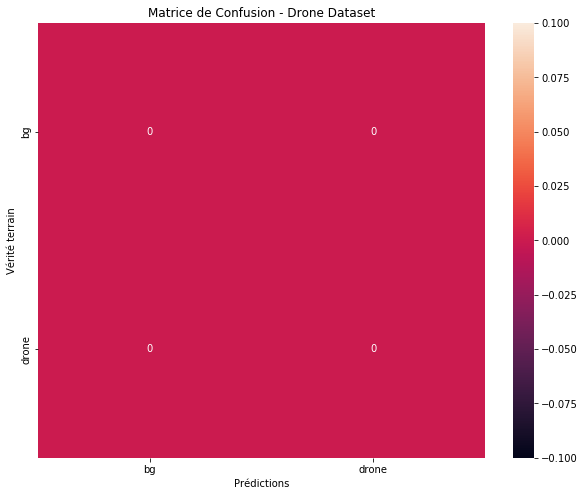

In [17]:
# 1. D'abord, importez les bibliothèques nécessaires
import numpy as np
from tqdm import tqdm

# Créer une instance du modèle en mode d'inférence
model = MaskRCNN(mode="inference", config=config, model_dir="./")

# Charger les poids du modèle (par exemple, ceux d'un modèle pré-entraîné)
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')
model.load_weights(model_path, by_name=True)

# 2. Évaluez votre modèle sur le dataset de validation
print("Évaluation du modèle sur le dataset de validation...")
confusion_mat = evaluer_drone_model(model, val_dataset, config)

# 3. Affichez la matrice de confusion
print("\nMatrice de confusion:")
print(confusion_mat)

# 4. Affichez les métriques détaillées
afficher_metriques(confusion_mat, config.CLASS_NAMES)

# 5. Visualisation avec seaborn (optionnel)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, 
            annot=True, 
            fmt='d',
            xticklabels=config.CLASS_NAMES,
            yticklabels=config.CLASS_NAMES)
plt.title('Matrice de Confusion - Drone Dataset')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()

In [20]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ['BG', 'drone']  # Background and drone

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 20


In [24]:
#fine tuning code
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Utiliser le GPU pour l'entraînement
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 0.4
    CLASS_NAMES = ['BG', 'drone']  # Background and drone
    STEPS_PER_EPOCH = 100


# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241123T1349'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)

# Load the dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir="dataset", subset="train")
dataset_train.prepare()

dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir="dataset", subset="val")
dataset_val.prepare()

total_epochs = 30
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=total_epochs,
            layers='heads')

Re-starting from epoch 20

Starting at epoch 20. LR=0.0001

Checkpoint Path: logs/drone_detection20241123T1349\drone_detection20241123T1349\mask_rcnn_drone_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed

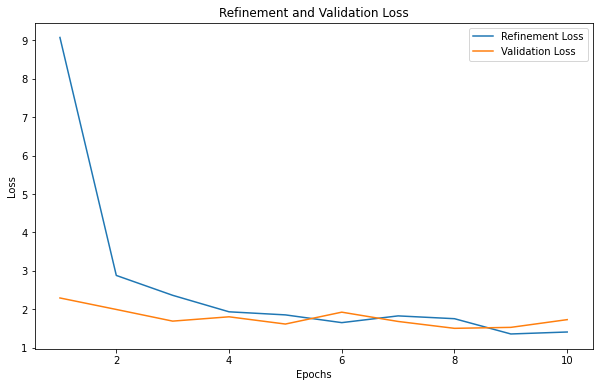

In [1]:
import matplotlib.pyplot as plt

# Données des époques
epochs = range(1, 11)

# Pertes d'entraînement et de validation
loss = [9.0770, 2.8810, 2.3637, 1.9342, 1.8540, 1.6523, 1.8279, 1.7547, 1.3570, 1.4083]
val_loss = [2.2946, 1.9952, 1.6916, 1.8040, 1.6155, 1.9248, 1.6830, 1.5038, 1.5291, 1.7303]

# Tracer les courbes de pertes
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, label='Refinement Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Refinement and Validation Loss')
plt.legend()
plt.show()

